# Preparation

## Import packages

In [1]:
import os, sys
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import math
import copy
import time

In [2]:
from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import merge, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.layers.merge import concatenate
from keras.layers.core import Dropout, Lambda
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## Read input

In [3]:
# Band 1: blue; Band 2: green; Band 3: red; Band 4: nir
I = np.load(os.path.join('../data/Training.npy'))
I.shape

(4, 3344, 244, 244)

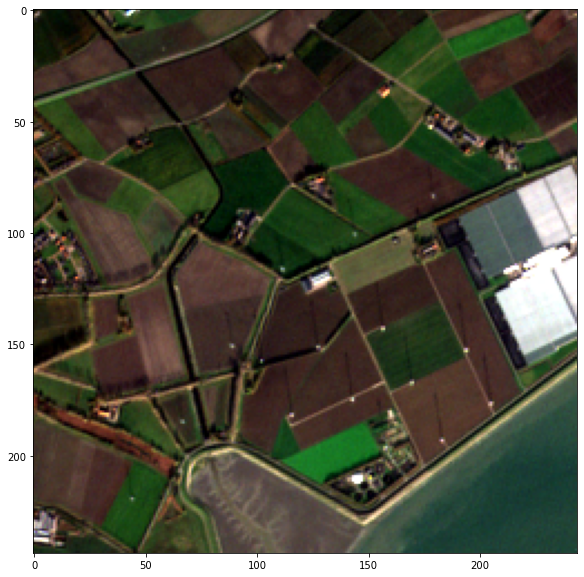

In [4]:
idx = 50
tmp = np.zeros((I.shape[2], I.shape[3], 3), dtype=np.uint8)
for q in range(3):
    a = copy.copy(I[q,idx,:,:])
    D = a>0
    prc = np.percentile(a[D],[1,99])
    tmp[:,:,2-q] = np.digitize(a,np.linspace(prc[0],prc[1],255))*D
plt.imshow(tmp)
f = plt.gcf()
f.set_size_inches(10, 10)
plt.show()

In [5]:
T = np.load('../data/Targets.npy')
T.shape

(3344, 244, 244)

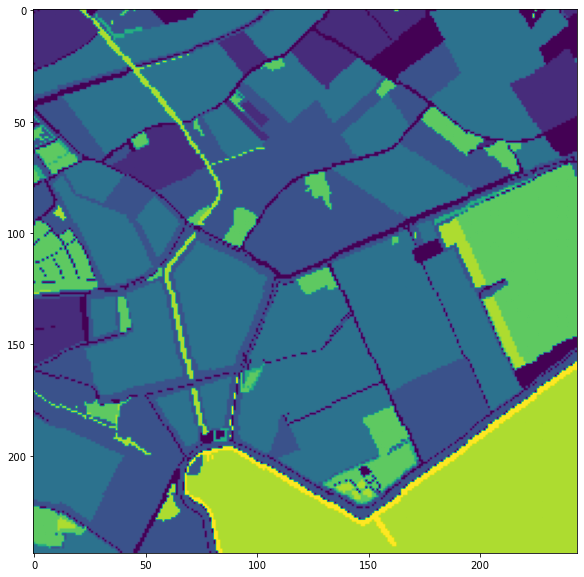

In [6]:
plt.imshow(T[idx,:,:])
f = plt.gcf()
f.set_size_inches(10, 10)
plt.show()

In [7]:
# Class 0 signifies nodata
classes = np.unique(T.flatten())
print(classes)

[0 1 2 3 4 5 6 7 8]


# Standardize data

In [8]:
X = np.float32(I)
X[X>10000] = 10000
X = X / 10000.
X.shape

(4, 3344, 244, 244)

In [9]:
X = np.rollaxis(X, 0, 4)
xshape = X.shape
print(xshape)

(3344, 244, 244, 4)


In [10]:
mu = np.zeros((4,))
std = np.zeros((4,))
for q in range(X.shape[3]):
    tmp = copy.copy(X[:, :, :, q])
    tmp = tmp.flatten()
    mu[q] = tmp[tmp>0].mean()
    std[q] = tmp[tmp>0].std()
    print(mu[q], std[q])
    tmp[tmp>0] = (tmp[tmp>0] - mu[q]) / std[q]
    X[:, :, :, q] = tmp.reshape(X.shape[0], X.shape[1], X.shape[2])
    del tmp

0.12655076384544373 0.016980711370706558
0.09710454940795898 0.016959035769104958
0.07182221114635468 0.023930516093969345
0.17956602573394775 0.12075547128915787


# Prepare targets

In [11]:
Y = np.zeros(T.shape +  (len(classes),), dtype=np.float32)
for q in range(len(classes)):
    tmp = Y[:,:,:,q]
    tmp[T==q] = 1
    Y[:,:,:,q] = tmp
print(Y.shape)

(3344, 244, 244, 9)


In [12]:
Y1= Y[:,:224,:224,:]

In [13]:
X1= X[:,:224,:224,:]

# U-net

In [16]:
from tensorflow.keras import layers
from tensorflow import keras

img_size=(224, 224, 4)
num_classes = len(classes)

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size )

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2,  padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 32) 1184        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [17]:
batch_size = 16
epochs = 100

callbacks = [
    keras.callbacks.EarlyStopping(patience=5),
    keras.callbacks.ModelCheckpoint("../checkpoints/test.h5", save_best_only=True),
    keras.callbacks.ModelCheckpoint(filepath='../weights/model.{epoch:02d}-{val_loss:.2f}.h5'),
    keras.callbacks.TensorBoard(log_dir='./logs'),
]


model.compile(optimizer="rmsprop", loss="categorical_crossentropy")


In [18]:
t = time.time()

model.fit(X1, Y1, batch_size=batch_size, epochs=epochs, verbose=1, 
                     validation_split=0.2, callbacks=callbacks)
print('Elapsed time for training: %.02f sec' % (time.time() - t))

Epoch 1/100
  1/168 [..............................] - ETA: 0s - loss: 5.8539WARNING:tensorflow:From /home/bd/anaconda3/envs/tf-gpu4/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
168/168 [==============================] - 29s 175ms/step - loss: 1.5621 - val_loss: 2.6093
Epoch 2/100
168/168 [==============================] - 27s 160ms/step - loss: 0.9197 - val_loss: 2.6003
Epoch 3/100
168/168 [==============================] - 27s 161ms/step - loss: 0.8668 - val_loss: 1.4749
Epoch 4/100
168/168 [==============================] - 27s 160ms/step - loss: 0.8127 - val_loss: 1.4319
Epoch 5/100
168/168 [==============================] - 27s 161ms/step - loss: 0.7798 - val_loss: 1.3688
Epoch 6/100
168/168 [==============================] - 27s 161ms/step - loss: 0.7584 - val_loss: 1.3107
Epoch 7/100


In [19]:
model.save("../models/model5.h5")


In [ ]:
# U-net
model.load_weights(filepath = 'model-224.h5')

score = model.evaluate(X1, Y1, verbose=0)


In [ ]:
score

# RESULTS

https://cidportal.jrc.ec.europa.eu/services/webview/jeodpp/ml-showcase/